In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%bash
uname -a
whoami

which cmsRun

Linux vinavx3.cern.ch 3.10.0-693.2.2.el7.x86_64 #1 SMP Tue Sep 12 22:26:13 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
/cvmfs/cms.cern.ch/slc7_amd64_gcc630/cms/cmssw/CMSSW_9_4_0/bin/slc7_amd64_gcc630/cmsRun


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool
from DataFormats.FWLite import Handle, Events
from FWLiteUtils import *

Welcome to JupyROOT 6.10/09


In [4]:
def loadTracks(tracks, weight, tkParsA) :
    for tk in tracks.product() :
        if not tk.trackHighPurity() : continue
        if (tk.pt()<0.7) : continue
        # if (abs(tk.dz(pvp))>0.5) : continue # only PV tracks
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(), weight])


In [5]:
def loop(args) :
    tkParsA = []
    ne = 0
    files = args[0]
    l = args[1]
    for f in files :
        print f
        events = Events(f)
        ls = eventsInLumiRange(events,l[0],l[1])
        if ls[0] eq ls[1] : continue
        mini = Mini()
        a= events.to(ls[0])
        mini.set(events)
        zbi = mini.zbIndex(events)
        print "ZB indeces: ", zbi
        names = events.object().triggerNames(mini.triggerBits[0].product())
        for i in xrange(mini.triggerBits[0].product().size()):
            if mini.triggerBits[0].product().accept(i) :print "Trigger ", i, names.triggerName(i)
        rid = runid(events,mini.lumi[0]) 
        for i in range(ls[0],ls[1]) :
          a= events.to(i)
          mini.set(events)
          ok = False
          for t in zbi : 
            if (mini.triggerBits[0].product().accept(t)) :
                ok = True
                break
          if (i%5000==0) : 
            evid = runid(events,mini.lumi[0])
            print "Event", i , evid
          if not ok : continue
          weight = 100./mini.ilumi()
          ne+=1
          loadTracks(mini.cand[0], weight, tkParsA)
          loadTracks(mini.ltk[0], weight, tkParsA)
      
    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA), dtype=np.float)
    print len(tkPars)
    print 'done'
    return (rid,ne,tkPars)

In [6]:
f1 = fullFileName(tier0+'/store/data/Run2017F/ZeroBias4/MINIAOD/PromptReco-v1/000/306/432/00000/', \
['2E885A64-3EC7-E711-8D0D-02163E019C87.root','8E9534C0-40C7-E711-A529-02163E0140D6.root','D09D212D-51C7-E711-A545-02163E014412.root']
                 )
f2 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/135/00000/8C5C6752-63C5-E711-B4C4-02163E0120F0.root']
l1 = (174,186)
l2 = (300,330)
l3 = (0,1000)
p = Pool(4)
ret = p.map(loop,[(f1,l1),(f1,l2),(f2,l3)])
#ne,tkPars = zip(*ret)

ZB indeces:  [440, 441, 442, 443, 444, 445, 446, 447, 448]
Trigger  502 HLT_ZeroBias_FirstCollisionAfterAbortGap_v5
Event 0 306135:94:1.50e+04
ZB indeces:  [447, 448, 449, 450, 451, 452, 453, 454, 455]
Trigger  451 HLT_ZeroBias_part3_v6
Trigger  456 DST_ZeroBias_v2
Trigger  497 AlCa_EcalPhiSym_v8
ZB indeces:  [447, 448, 449, 450, 451, 452, 453, 454, 455]
Trigger  451 HLT_ZeroBias_part3_v6
Trigger  456 DST_ZeroBias_v2
ZB indeces:  [447, 448, 449, 450, 451, 452, 453, 454, 455]
Trigger  451 HLT_ZeroBias_part3_v6
Trigger  456 DST_ZeroBias_v2
Trigger  497 AlCa_EcalPhiSym_v8
Event 0 306432:175:1.79e+03
Event 5000 306135:109:1.47e+04
Event 5000 306432:175:1.80e+03
Event 10000 306432:178:1.82e+03
Event 10000 306135:134:1.49e+04
Event 15000 306432:178:1.79e+03
Event 20000 306432:179:1.79e+03
Event 25000 306432:179:1.74e+03
Event 15000 306135:136:1.50e+04
Event 30000 306432:181:1.76e+03
Event 365000 306432:300:3.15e+02
ZB indeces:  [447, 448, 449, 450, 451, 452, 453, 454, 455]
Trigger  451 HLT_Z

In [7]:
p.terminate()

In [14]:
def plots(ret) :
    eta=0
    phi=1
    pt=2
    w=3
    yy = []
    for rid,ne,tkPars in ret :
      ya,x = np.histogram(tkPars[eta],np.linspace(-3.1,3.1,62),weights=10./float(ne)*tkPars[w])
      x.resize(len(ya))
      yy.append(ya)
      plt.step(x,ya,where='post',label=rid)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1,3.1)
    plt.xlabel('eta')
    plt.ylabel('dn/deta')
    plt.show()

    k=0
    for y in yy :
        plt.step(x,y/yy[0],where='post',label=ret[k][0])
        k+=1
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1,3.1)
    plt.xlabel('eta')
    plt.ylabel('eff')
    plt.show()


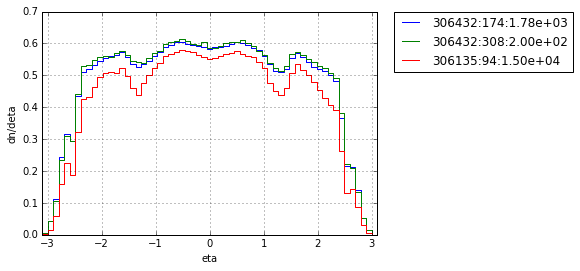

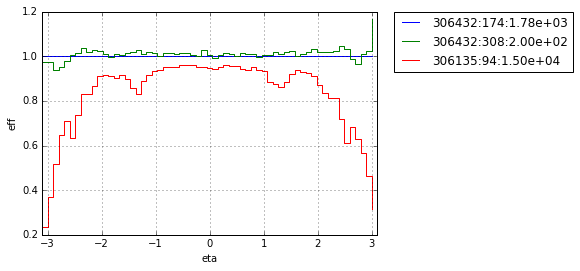

In [15]:
plots(ret)